In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from scipy import sparse
from sklearn.metrics import average_precision_score

In [2]:
scores = np.load('../processed_data/D4_largesample_short.npy')
#smiles = pd.read_csv('../processed_data/D4_largesample_short.smi')

In [13]:
(scores<-60).sum() / scores.shape[0] * 100

0.029157084291570844

In [10]:
np.percentile(scores, 1)

-51.28125

# Load the model from the small subsample

In [58]:
from sklearn.linear_model import LogisticRegression
from joblib import load
model = load('../processed_data/d4_smallModel.joblib') 
model

LogisticRegression(C=0.1, max_iter=10000)

# Fingerprint molecules
Only needs to be done once, then save it. 

In [22]:
# from rdkit import Chem
# from rdkit.Chem import rdMolDescriptors
# from scipy import sparse

# fingerprint_function = rdMolDescriptors.GetMorganFingerprintAsBitVect
# pars = { "radius": 2,
#                      "nBits": 32_768,
#                      "invariants": [],
#                      "fromAtoms": [],
#                      "useChirality": False,
#                      "useBondTypes": True,
#                      "useFeatures": True,
#             }




# #store bit indices in these:
# row_idx = list()
# col_idx = list()
        
# #iterate through file, 
# for count, smi in tqdm.tqdm_notebook(enumerate(smiles['smiles']), total=10_000_000):
#     mol = Chem.MolFromSmiles(smi)
#     fp = fingerprint_function(mol, **pars)
#     onbits = list(fp.GetOnBits())
#     #these bits all have the same row:
#     row_idx += [count]*len(onbits)
#     #and the column indices of those bits:
#     col_idx+=onbits
            

        
# #generate a sparse matrix out of the row,col indices:
# unfolded_size = 32_768
# fingerprint_matrix = sparse.coo_matrix((np.ones(len(row_idx)).astype(bool), (row_idx, col_idx)), 
#                           shape=(max(row_idx)+1, unfolded_size))
# #convert to csr matrix, it is better:
# fingerprint_matrix =  sparse.csr_matrix(fingerprint_matrix)

In [23]:
# #save it so we can reload:
# sparse.save_npz('../processed_data/d4_morgan_feat_large.npz', fingerprint_matrix)

In [24]:
fingerprint_matrix = sparse.load_npz('../processed_data/d4_morgan_feat_large.npz')

# Predict using the previously fitted model

In [99]:
model = load('../processed_data/d4_smallModel.joblib') 

proba = model.predict_proba(fingerprint_matrix)[:,1]
topK = scores <np.percentile(scores, 1.)
#topK = scores <-50


In [100]:
average_precision_score(topK, proba)

0.10802499429531039

In [ ]:
#-50, ap = 0.15420473330120524
#-55, ap = 0.12844461392699513
#-60, ap = 0.10210099984533529
#-47, ap = 0.15562447168992408

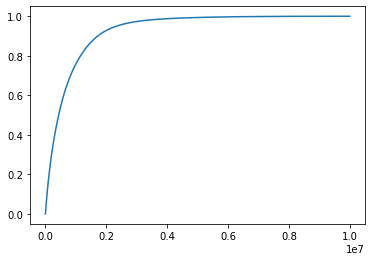

In [68]:
plt.plot(topK[(-proba).argsort()].cumsum()/topK.sum())

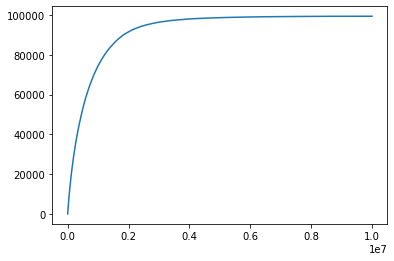

In [37]:
plt.plot( test[(-proba).argsort()].cumsum() )

(array([1.000e+00, 0.000e+00, 6.000e+00, 1.100e+01, 3.100e+01, 9.900e+01,
        2.570e+02, 6.320e+02, 1.290e+03, 2.117e+03, 3.164e+03, 4.080e+03,
        4.963e+03, 4.744e+03, 4.574e+03, 4.008e+03, 3.520e+03, 3.065e+03,
        2.716e+03, 2.436e+03, 1.888e+03, 1.523e+03, 1.162e+03, 9.120e+02,
        6.930e+02, 5.130e+02, 3.960e+02, 3.040e+02, 2.080e+02, 1.620e+02,
        1.310e+02, 8.800e+01, 6.800e+01, 4.300e+01, 4.400e+01, 3.900e+01,
        2.800e+01, 1.900e+01, 1.000e+01, 1.200e+01, 4.000e+00, 7.000e+00,
        1.100e+01, 7.000e+00, 2.000e+00, 6.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([-75.5  , -73.4  , -71.2  , -69.06 , -66.94 , -64.75 , -62.62 ,
        -60.47 , -58.34 , -56.2  , -54.03 , -51.9  , -49.75 , -47.6  ,
        -45.47 , -43.3  , -41.16 , -39.03 , -36.88 , -34.72 , -32.6  ,
        -30.44 , -28.3  , -26.16 , -24.   , -21.86 , -19.72 , -17.56 ,
        -15.42 , -13.27 , -11.13 ,  -8.984,  -6.84 ,  -4.695,  -2.549,
         -0.403,   1.

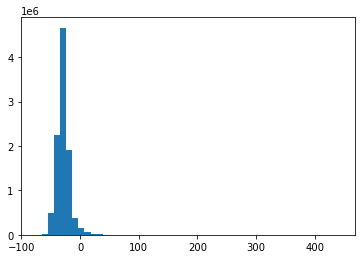

In [14]:
plt.hist(scores,bins=50)
plt.hist(scores[(-proba).argsort()][:50000],bins=50)


# Run some monte carlo cross validation to double check the cutoff gives  reasonably similar results as AmpC

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score as apscore

y = (scores<cutoff).astype(int)

for i in range(10):
    idx = np.arange(len(y))
    np.random.shuffle(idx)
    
    train = idx[:np.int(len(y)*0.9)]
    test = idx[np.int(len(y)*0.9):]
    
    model = LogisticRegression(max_iter=10000,C=0.1)
    model.fit(fingerprint_matrix[train], y[train])
    
    #print performance improvement above a random classifier. 
    ap = apscore(y[test],model.predict_proba(fingerprint_matrix[test])[:,1])
    print(ap)


0.23005970241472906
0.22838276784323344
0.24377199545533457
0.2438595221500688
0.24770337510692148
0.23930417654716402
0.23839419718817684
0.2237980829960702
0.24600624932769033
0.3187201009658738
